In [25]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

In [26]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [27]:
train = gen.flow_from_directory("BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")
                
val = gen.flow_from_directory("BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [28]:
classes

{'BrainTumor': 0, 'Healthy': 1}

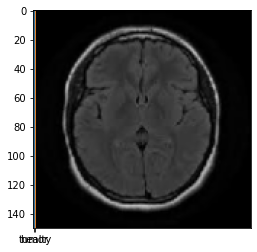

In [29]:
t=0
h=0
for i in range(15):
    a, b = next(train)
    for j in b:
        if j == 1:
            h+=1
        else:t+=1

sns.barplot(x=['tumor','healty'],y=[t,h])
import matplotlib.pyplot as plt
batch = next(train)

plt.imshow(batch[0][0])

In [30]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten, Input
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras import layers

In [31]:
input_tensor = Input(shape=(100, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

resnet_model = ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable=False

resnet = Sequential()
resnet.add(resnet_model)
resnet.add(layers.Conv2D(32, kernel_size=(3,3), strides=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
resnet.add(layers.ReLU())
resnet.add(layers.MaxPooling2D(pool_size=(2,2)))
resnet.add(layers.Flatten())
resnet.add(layers.Dense(activation='relu', units=64))
resnet.add(layers.Dropout(0.2))
resnet.add(layers.Dense(activation='sigmoid', units=1))

resnet.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               11214976  
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

In [32]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [33]:
history = resnet.fit(train,verbose=1,callbacks = [earlystopping],epochs=3,validation_data=(val))

Epoch 1/3
15/15 [==============================] - 37s 2s/step - loss: 0.6103 - accuracy: 0.6946 - val_loss: 0.5552 - val_accuracy: 0.7497
Epoch 2/3
15/15 [==============================] - 35s 2s/step - loss: 0.3601 - accuracy: 0.8413 - val_loss: 0.3760 - val_accuracy: 0.8368
Epoch 3/3
15/15 [==============================] - 34s 2s/step - loss: 0.1949 - accuracy: 0.9291 - val_loss: 0.2902 - val_accuracy: 0.9304


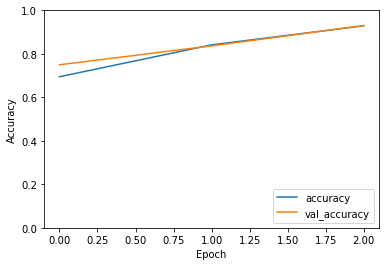

In [34]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


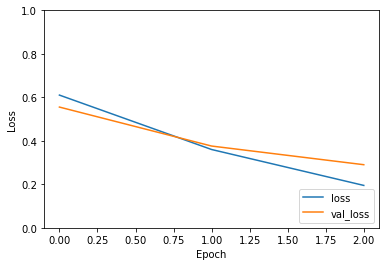

In [35]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [36]:
gen = ImageDataGenerator(rescale=1./255,zoom_range=(0.99,0.99),dtype=tf.float32)
test = gen.flow_from_directory("Test/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")

classes = val.class_indices

Found 4600 images belonging to 2 classes.


In [37]:
_, acc  = resnet.evaluate(test, verbose=1)

18/18 [==============================] - 23s 1s/step - loss: 0.3059 - accuracy: 0.9443
